# Player Performance Prediction Model

This notebook builds a deep learning model to predict a player's `overall_rating`.

**Steps:**
1.  Load the cleaned dataset.
2.  Select relevant features for performance prediction.
3.  Preprocess the data (handle categorical features, scale numerical features).
4.  Build a neural network using TensorFlow/Keras.
5.  Train and evaluate the model.
6.  Save the model and preprocessing objects for deployment.


### 1. Import Libraries


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import joblib
import json

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.19.0


### 2. Load and Prepare Data


In [2]:
# Load the dataset
df = pd.read_csv('/content/fifa_players_cleaned.csv')

In [3]:
# Set some important variables
target = 'overall_rating'
TEST_SIZE = 0.2
RANDOM_STATE = 42

### 2.1 Feature Correlation Analysis

Before preprocessing, let's analyze the correlation between our the numerical features and the `target` variable, `overall_rating`. This helps us in feature selection.


/tmp/ipython-input-1647583926.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=full_rating_correlation.values, y=full_rating_correlation.index, palette='viridis')


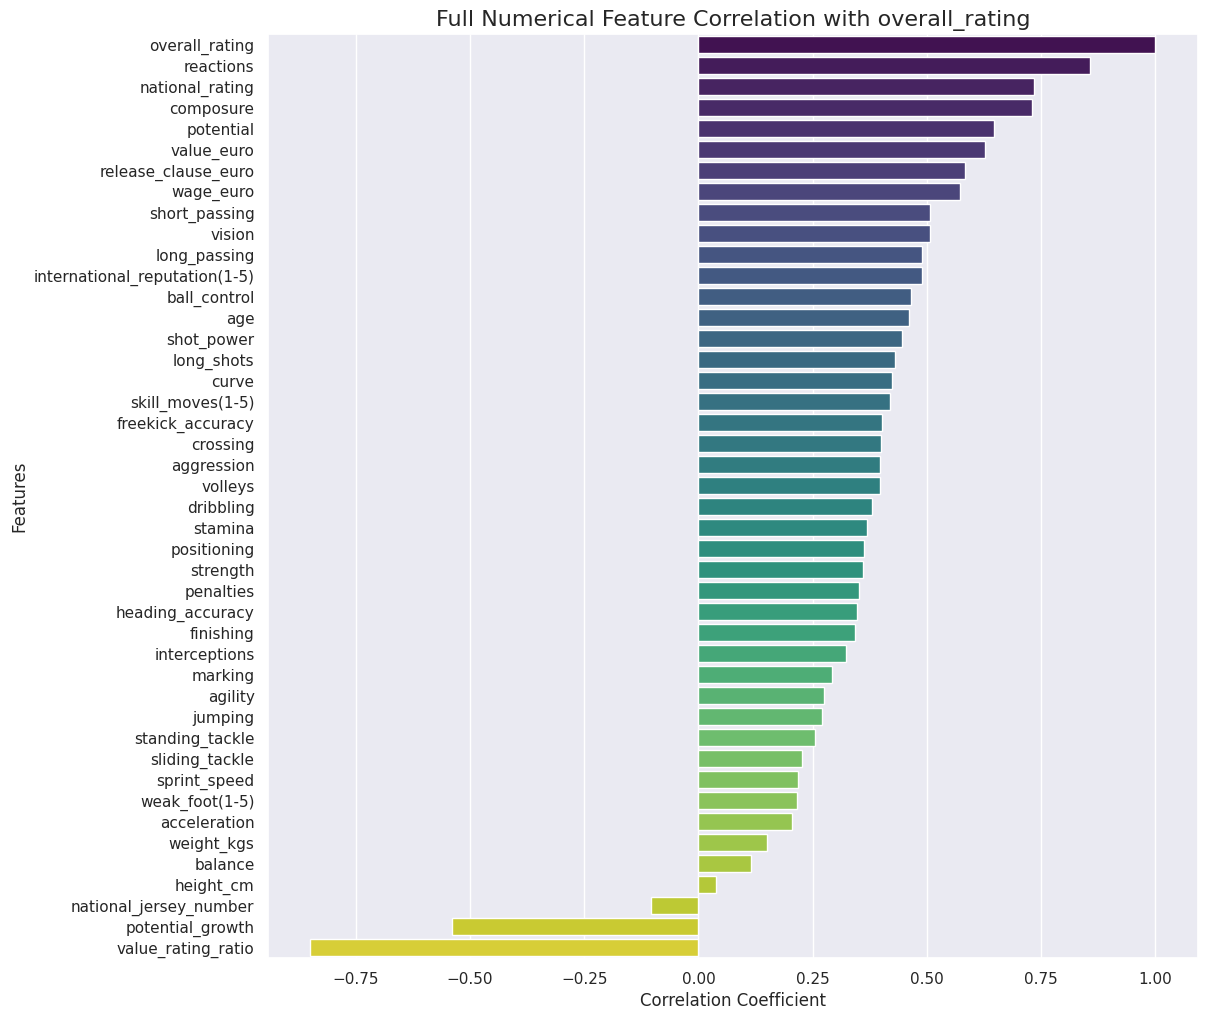

Full correlation list with Overall Rating:
overall_rating                   1.000000
reactions                        0.855767
national_rating                  0.733395
composure                        0.729278
potential                        0.647249
value_euro                       0.626326
release_clause_euro              0.583244
wage_euro                        0.573311
short_passing                    0.506819
vision                           0.506812
long_passing                     0.489998
international_reputation(1-5)    0.489416
ball_control                     0.464336
age                              0.461529
shot_power                       0.445306
long_shots                       0.429458
curve                            0.423890
skill_moves(1-5)                 0.418718
freekick_accuracy                0.400878
crossing                         0.398343
aggression                       0.397072
volleys                          0.396922
dribbling                        

In [4]:
# To understand feature importance and potential data leakage, let's analyze the correlation
# of ALL numerical features in the original cleaned dataset with our target.
df_numerical = df.select_dtypes(include=np.number)

# The 'potential_growth' and 'value_rating_ratio' columns were created during EDA.
# If they don't exist in the loaded CSV, we can recreate them for this analysis.
if 'potential_growth' not in df_numerical.columns:
    df_numerical['potential_growth'] = df['potential'] - df['overall_rating']
if 'value_rating_ratio' not in df_numerical.columns:
    # Add 1 to value to avoid division by zero for free players
    df_numerical['value_rating_ratio'] = df['overall_rating'] / (df['value_euro'] / 1e6 + 1)

full_correlation_matrix = df_numerical.corr()

# Sort the correlation metrix
full_rating_correlation = full_correlation_matrix[target].sort_values(ascending=False)

# Plot the full correlations for visualization
plt.figure(figsize=(12, 12))
sns.barplot(x=full_rating_correlation.values, y=full_rating_correlation.index, palette='viridis')
plt.title(f'Full Numerical Feature Correlation with {target}', fontsize=16)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

print("Full correlation list with Overall Rating:")
print(full_rating_correlation)


### 2.1.1 Interpretation of Correlations and Feature Selection Strategy

From the correlation analsysi, it is evident that there are multiple features that are strongly correlated tot he `target` variable. Nevertheless, selecting thme for our model training would lead to the phenomenon of `Data Leakage`.

**1. Identifying Data Leakage (Features to Exclude):**

We observe extremely high correlations from several features:
*   `value_euro`
* `release_clause_euro`
* `wage_euro`

These financial metrics are a direct **result** of a player's high rating, not a cause of it. That is, these featurres depend on the target variable, since a club pays a player a high wage *because* they are good. Including these would be telling the model the answer indirectly, and this is referred to as **data leakage**.

*   `national_rating`: This is the player's rating when playing for their national team. It's too similar to `overall_rating` and can be considered a form of data leakage.
*   `potential_growth` and `value_rating_ratio`: These are features we engineered during EDA that were calculated using `overall_rating`. Including them would be a direct leak of the target variable.

Using these features would create a model that looks great on paper (high accuracy on the test set) but fails in the real world because it hasn't learned the underlying relationship between a player's skills and their rating.

**2. Selecting Causal Features:**

Based on the above, we will proceed with a curated list of features that are **causes** of a player's rating, not outcomes. Our selection focuses on:

-   **Core Skills**: Attributes that are the true drivers of a player's ability.
   * `ball_control`
   * `reactions`
   * `composure`
   * `short_passing`

-   **Player Foundation**:
   * `potential` represents a player's ceiling.
   * `age` defines their career stage.
*   **Physicality**: Essential athletic attributes like,
   * `stamina`
   * `strength`

**Conclusion**: We are deliberately excluding features that lead to data leakage. In this way, we will build a more robust and realistic model. This model will learn to predict a player's rating based on their fundamental abilities, which is the true goal of our IDSS.

### 2.2 Curated Feature Selection and Preparation


In [5]:
# Based on our correlation analysis and to avoid data leakage, we select a curated
# list of features that are causes of a player's rating, not outcomes.
features = [
    # Player Metadata
    'age', 'potential',
    # Key Technical Skills
    'reactions', 'composure', 'short_passing', 'ball_control', 'vision',
    'dribbling', 'long_passing', 'finishing', 'crossing', 'heading_accuracy',
    'volleys', 'curve', 'freekick_accuracy', 'long_shots', 'aggression',
    'interceptions', 'positioning', 'penalties', 'marking', 'standing_tackle',
    'sliding_tackle', 'shot_power', 'jumping',
    # Key Physical Skills
    'stamina', 'strength', 'acceleration', 'sprint_speed', 'agility', 'balance',
    # Other Skills
    'international_reputation(1-5)', 'weak_foot(1-5)', 'skill_moves(1-5)',
    # Categorical Features for context
    'positions', 'preferred_foot', 'body_type', 'nationality'
]

df_model = df[features + [target]].copy()

# For simplicity, we'll handle nationality by taking the top N most frequent ones
# and grouping the rest. This avoids creating too many one-hot encoded features.
top_n_nationalities = 20
top_nationalities = df_model['nationality'].value_counts().nlargest(top_n_nationalities).index
df_model['nationality'] = df_model['nationality'].where(df_model['nationality'].isin(top_nationalities), 'Other')

print("Selected features for the model:")
df_model.head()

Selected features for the model:


,age,potential,reactions,composure,short_passing,ball_control,vision,dribbling,long_passing,finishing,...,agility,balance,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),positions,preferred_foot,body_type,nationality,overall_rating
0,31,94,95,96,92,96,94,97,89,95,...,93,95,5,4,4,"CF,RW,ST",Left,Messi,Argentina,94
1,27,89,88,88,91,91,91,84,89,81,...,80,81,3,5,4,"CAM,RM,CM",Right,Lean,Other,88
2,25,91,82,87,86,90,88,87,90,75,...,76,66,4,4,5,"CM,CAM",Right,Normal,France,88
3,27,88,83,83,85,93,87,90,78,77,...,94,93,3,4,4,"LW,ST",Right,Normal,Italy,88
4,27,91,82,80,68,63,49,69,60,22,...,50,40,3,3,2,CB,Right,Normal,Other,88


In [6]:
print("\\nInfo about the final model dataframe:")
df_model.info()

\nInfo about the final model dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17954 entries, 0 to 17953
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   age                            17954 non-null  int64 
 1   potential                      17954 non-null  int64 
 2   reactions                      17954 non-null  int64 
 3   composure                      17954 non-null  int64 
 4   short_passing                  17954 non-null  int64 
 5   ball_control                   17954 non-null  int64 
 6   vision                         17954 non-null  int64 
 7   dribbling                      17954 non-null  int64 
 8   long_passing                   17954 non-null  int64 
 9   finishing                      17954 non-null  int64 
 10  crossing                       17954 non-null  int64 
 11  heading_accuracy               17954 non-null  int64 
 12  volleys             

### 3. Preprocessing


In [7]:
# Separate features and target
X = df_model.drop(target, axis=1)
y = df_model[target]

# Identify categorical and numerical features
categorical_features = ['positions', 'preferred_foot', 'body_type', 'nationality']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Save the column order/names for consistent inference
model_columns = X.columns.tolist()

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [9]:
# Scale numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (14363, 953)
Test data shape: (3591, 953)


### 4. Build the Neural Network


In [10]:
def build_performance_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu'),
        layers.Dense(1) # Output layer for regression (no activation)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [11]:
# Get the input shape from the training data
input_shape = [X_train.shape[1]]
model = build_performance_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       488,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,577 (2.54 MB)

 Trainable params: 662,785 (2.53 MB)

 Non-trainable params: 1,792 (7.00 KB)

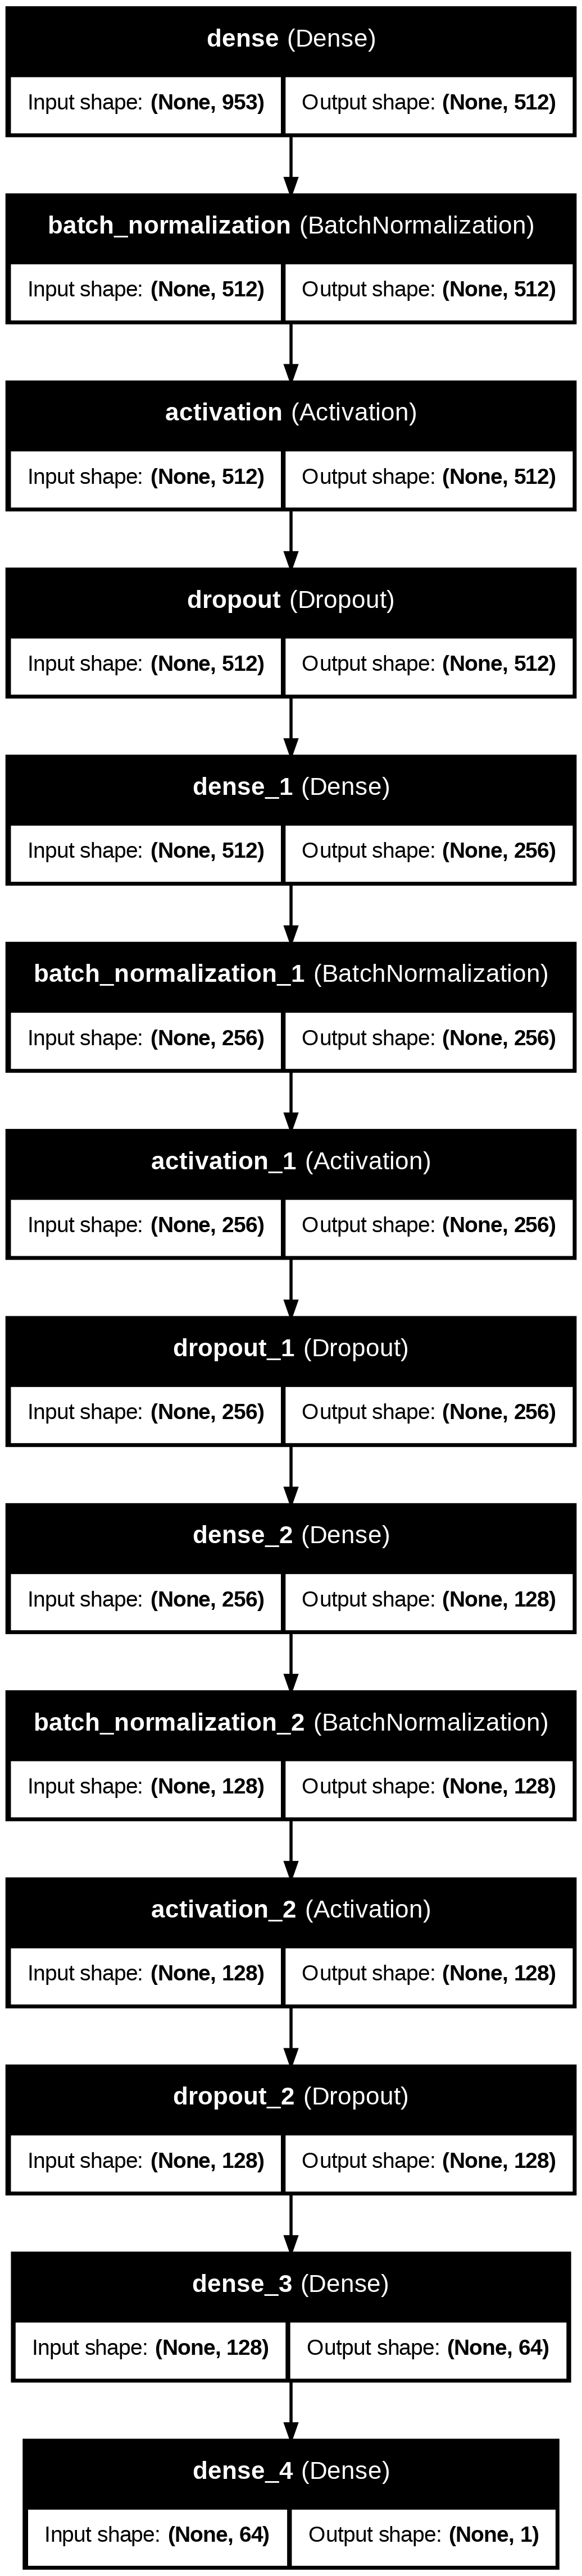

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

### 5. Train the Model


In [13]:
# Add callbacks to prevent overfitting and adjust learning rate
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

epochs = 200
batch_size = 64

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 2520.3608 - mean_absolute_error: 45.4151 - mean_squared_error: 2520.3608 - val_loss: 422.8980 - val_mean_absolute_error: 20.1595 - val_mean_squared_error: 422.8980 - learning_rate: 0.0010
Epoch 2/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 37.5958 - mean_absolute_error: 4.8636 - mean_squared_error: 37.5958 - val_loss: 49.7241 - val_mean_absolute_error: 6.6574 - val_mean_squared_error: 49.7241 - learning_rate: 0.0010
Epoch 3/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 29.1374 - mean_absolute_error: 4.2804 - mean_squared_error: 29.1374 - val_loss: 6.3853 - val_mean_absolute_error: 2.0994 - val_mean_squared_error: 6.3853 - learning_rate: 0.0010
Epoch 4/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 27.4171 - mean_absolute_error: 4.1722 - mean_squared_error: 27.4171 - val_loss: 4.2308 - val_mean_absolute_error: 1.6305 - val_mean_squared_error: 4.2308 - learning_rate: 0.0010
Epoch 5/200
180/180 ━━━━━━━━

### 6. Evaluate the Model


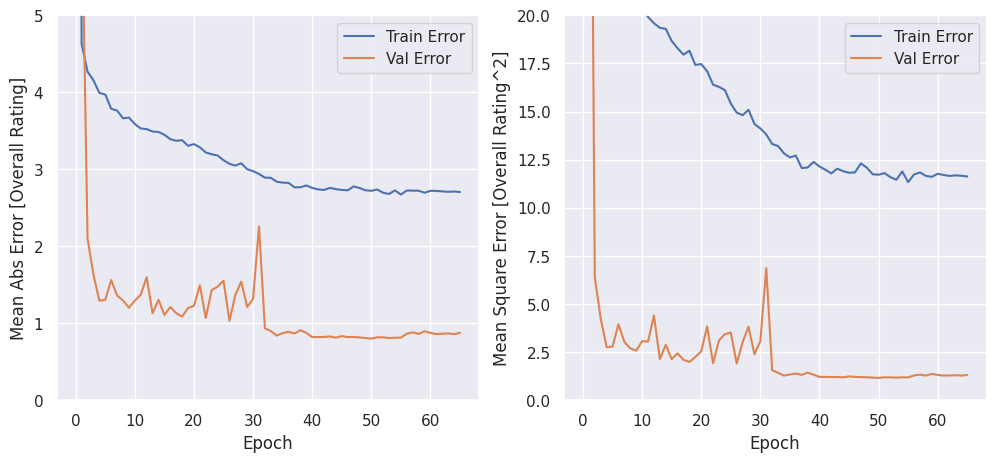

In [14]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Overall Rating]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Overall Rating^2]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)


113/113 - 0s - 4ms/step - loss: 1.2001 - mean_absolute_error: 0.7989 - mean_squared_error: 1.2001
\nTest set Mean Abs Error:  0.80 Overall Rating
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


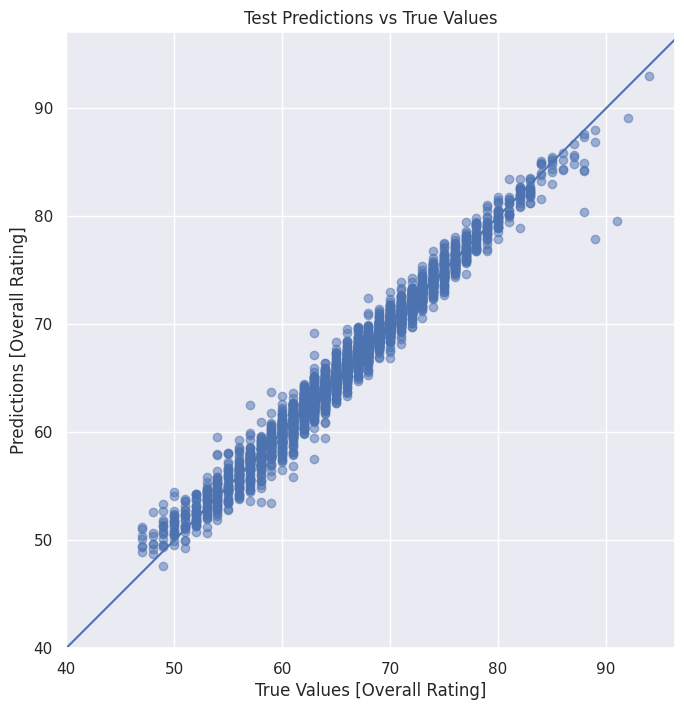

R^2 Score on Test Data: 0.9760


In [15]:
# Evaluate on test data
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("\\nTest set Mean Abs Error: {:5.2f} Overall Rating".format(mae))

# Make predictions
test_predictions = model.predict(X_test).flatten()

# Scatter plot of predictions vs true values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.xlabel('True Values [Overall Rating]')
plt.ylabel('Predictions [Overall Rating]')
plt.axis('equal')
plt.axis('square')
plt.xlim([40, plt.xlim()[1]])
plt.ylim([40, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.title('Test Predictions vs True Values')
plt.show()

# R^2 Score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, test_predictions)
print(f"R^2 Score on Test Data: {r2:.4f}")


##6.1 Summary of Player Performance Model Performance

* **Overall Assessment**

The deep learning model developed for predicting a player's `overall_rating` has demonstrated exceptional performance and high accuracy. The results from training, validation, and final testing on unseen data indicate that the model is robust, well-generalized, and fit for purpose within the Intelligent Decision Support System (IDSS) for Football player selection.

* **Key Performance Metrics**

The model's success is quantified by the following key metrics on the test dataset:

    - *R-squared (R²) Score: 0.97*

An **R²** value of **0.97** is an outstanding result, indicating that the model is able to explain **97%** of the variance in player ratings. This signifies a very strong correlation between the features selected and the player's overall skill, confirming that our feature selection strategy was effective.

    - *Mean Absolute Error (MAE): 0.80*

The model's predictions are, on average, only **0.08** points away from the players' actual `overall_rating`. Given that player ratings are on a **1-100** scale, this low margin of error is excellent and demonstrates a high degree of precision. For the purpose of performance prediction and comparing players, this level of accuracy is more than sufficient.


* **Analysis of Training and Validation**

The training process was monitored to ensure the model did not overfit the training data and could generalize well to new data.

   - *Learning Curves*: The training and validation loss curves, as seen in the training history plots, followed each other closely and converged smoothly. This is a clear indication that the model is not overfitting. The validation error stabilized at a low value, and the **EarlyStopping** callback successfully halted the training process once the model ceased to improve, ensuring optimal performance without unnecessary computation.

   - *Prediction Accuracy Visualization*: The scatter plot comparing the model's predictions against the true values on the test set provides a strong visual confirmation of its accuracy. The data points form a tight, linear cluster around the 45-degree diagonal line, showing that the predictions are consistently close to the actual ratings across the entire skill spectrum, from lower-rated to elite players.


#### Conclusion

The combination of a high R² score, a low Mean Absolute Error, and stable learning curves confirms the success of the performance model. The careful feature selection, which focused on causal attributes and the avoidance of data leakage, has resulted in a powerful and reliable predictive tool. This model is well-suited for integration into the final DSS, where it will provide accurate, data-driven insights into player quality.

### 7. Save Model and Preprocessing Objects


In [16]:
# Save the model
model.save('performance_model.keras')

# Save the scaler
joblib.dump(scaler, 'performance_scaler.gz')

# Save the list of model columns
with open('performance_model_columns.json', 'w') as f:
    json.dump(model_columns, f)

# Save the list of numerical features for the scaler
with open('performance_numerical_columns.json', 'w') as f:
    json.dump(numerical_features, f)

# Save the top nationalities list
with open('performance_top_nationalities.json', 'w') as f:
    json.dump(top_nationalities.tolist(), f)

print("\\nModel, scaler, and column lists saved successfully.")


\nModel, scaler, and column lists saved successfully.


In [17]:
X_train.to_csv("X_train.csv",index=False)
X_test.to_csv("X_test.csv",index=False)
y_train.to_csv("y_train.csv",index=False)
y_test.to_csv("y_test.csv",index=False)

In [18]:
# --- Save the list of top nationalities ---
# Needed to correctly handle the 'nationality' feature for new players.
with open('performance_top_nationalities.json', 'w') as f:
    json.dump(top_nationalities.tolist(), f)

# --- Save the numerical columns list ---
# Needed to know which columns to apply the scaler to in your app.
with open('performance_numerical_columns.json', 'w') as f:
    json.dump(numerical_features, f)